In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [3]:
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels

import autoencoder
from AdvancedAutoencoder import AdvancedAutoencoder
from networks import WMAutoencoder, WM_VAE
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [4]:
from delve import CheckLayerSat

In [5]:
# BATCH_SIZE = 512
BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [6]:
class MineRlImageDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        initial_size = 1916597
        self.transform = transform
        self.pov = np.memmap(base_dir + '/pov.npy', dtype='uint8', mode='r', shape=(initial_size, 64, 64, 3))


    def __len__(self):
        return self.pov.shape[0]

    def __getitem__(self, idx):
        image = self.pov[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
dataset = MineRlImageDataset("data/npy_obtain_diamond")

In [8]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [9]:
train_features = next(iter(train_dataloader))
train_features.shape

torch.Size([256, 64, 64, 3])

In [10]:
theirs_f = torch.nn.Flatten()(train_features)
theirs_f.shape

torch.Size([256, 12288])

In [11]:
mine = unflatten(theirs_f)
mine.shape

torch.Size([256, 12288, 1, 1])

In [12]:
theirs = torch.nn.Unflatten(-1, (12288, 1, 1))(theirs_f)
theirs.shape

torch.Size([256, 12288, 1, 1])

In [13]:
torch.any(mine!=theirs)

tensor(False)

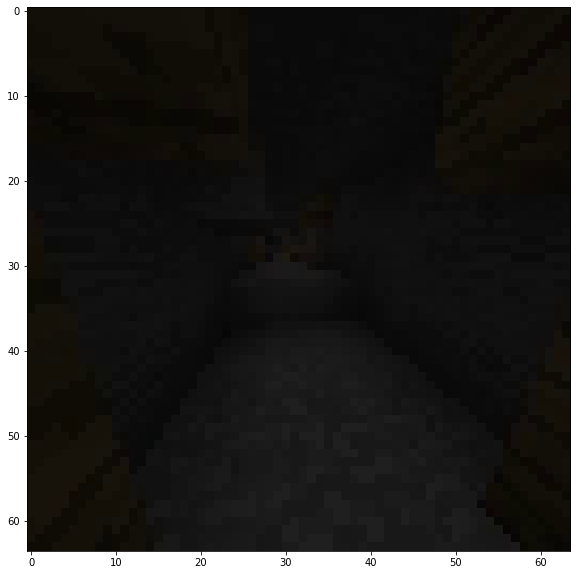

In [14]:
plt.imshow(train_features[10])

In [15]:
from pytorch_msssim import ssim

def vae_mixed_ssim_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = 0.1 * (1 - ssim(inputs, outputs, data_range=1, size_average=True, nonnegative_ssim=True, win_size=5)) + F.l1_loss(inputs, outputs)
    kl = autoencoder.kld_loss(mu, logvar) * .0
    return recon + kl, recon, kl

In [16]:
import torch.distributions as D

def vae_gaussian_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = -(D.Normal(outputs, torch.ones_like(outputs)).log_prob(inputs).mean())
    kl = autoencoder.kld_loss(mu, logvar)
    return recon + kl, recon, kl

In [17]:
def plain_gaussian_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = -(D.Normal(outputs, torch.ones_like(outputs)).log_prob(inputs).mean())
    kl = autoencoder.kld_loss(mu, logvar)
    return recon, recon, kl

In [18]:
def beta_gaussian_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = -(D.Normal(outputs, torch.ones_like(outputs)).log_prob(inputs).mean())
    kl = 0.01 * autoencoder.kld_loss(mu, logvar)
    return recon + kl, recon, kl

In [19]:
def train_batch(inputs, model, optimizer, loss_func):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, latents = model(inputs)

    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    loss = loss_func(inputs, outputs, latents)
    if isinstance(loss, tuple):
        loss[0].backward()
    else:
        loss.backward()
    
#     plot_grad_flow(model.named_parameters())

    nn.utils.clip_grad_value_(model.parameters(), 1.0)
    optimizer.step()
    return loss

In [20]:
loss_func = autoencoder.vae_l1_loss

In [21]:
class WM_VAE(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()
        activation = nn.ReLU
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2),
            activation(),
            nn.Conv2d(32, 64, 4, stride=2),
            activation(),
            nn.Conv2d(64, 128, 4, stride=2),
            activation(),
            nn.Conv2d(128, 256, 4, stride=2),
            activation(),
        )

        self.latent = nn.Linear(1024, latent_size)

        self.unlatent = nn.Linear(latent_size, 1024)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            activation(),
            nn.ConvTranspose2d(128, 64, 5, stride=2),
            activation(),
            nn.ConvTranspose2d(64, 32, 6, stride=2),
            activation(),
            nn.ConvTranspose2d(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        latent = self.latent(torch.flatten(encoded, 1))
        x = self.unlatent(latent)
        x = unflatten(x)
        decoded = self.decoder(x)
        return decoded, latent

In [22]:
import networks

In [23]:
model = networks.VisionVAE(256).cuda()

In [24]:
metrics_path = "metrics/" + datetime.datetime.now().isoformat() + "/"
metrics_path

'metrics/2021-09-23T22:39:03.098016/'

In [25]:
os.makedirs(metrics_path)

In [26]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.00025, amsgrad=True)

In [27]:
tracker = CheckLayerSat(metrics_path + "my_experiment", save_to="plotcsv", modules=model, device=next(model.parameters()).device)    

Skipping encoder-encoder-0-addcoords
added layer encoder-encoder-0-conv
Skipping encoder-encoder-1
Skipping encoder-encoder-2
Skipping encoder-encoder-3-addcoords
added layer encoder-encoder-3-conv
Skipping encoder-encoder-4
Skipping encoder-encoder-5
Skipping encoder-encoder-6-addcoords
added layer encoder-encoder-6-conv
Skipping encoder-encoder-7
Skipping encoder-encoder-8
Skipping encoder-encoder-9-addcoords
added layer encoder-encoder-9-conv
Skipping encoder-encoder-10
Skipping encoder-encoder-11
Skipping encoder-encoder-12
added layer latent-mu
added layer latent-logvar
added layer decoder-decoder-0
Skipping decoder-decoder-1
Skipping decoder-decoder-2
Skipping decoder-decoder-3
Skipping decoder-decoder-4
Skipping decoder-decoder-5-addcoords
Skipping decoder-decoder-5-conv
Skipping decoder-decoder-6
Skipping decoder-decoder-7
Skipping decoder-decoder-8-addcoords
Skipping decoder-decoder-8-conv
Skipping decoder-decoder-9
Skipping decoder-decoder-10
Skipping decoder-decoder-11-addco

In [28]:
image = train_features.permute(0, 3, 1, 2).cuda() / 255

metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_0.png


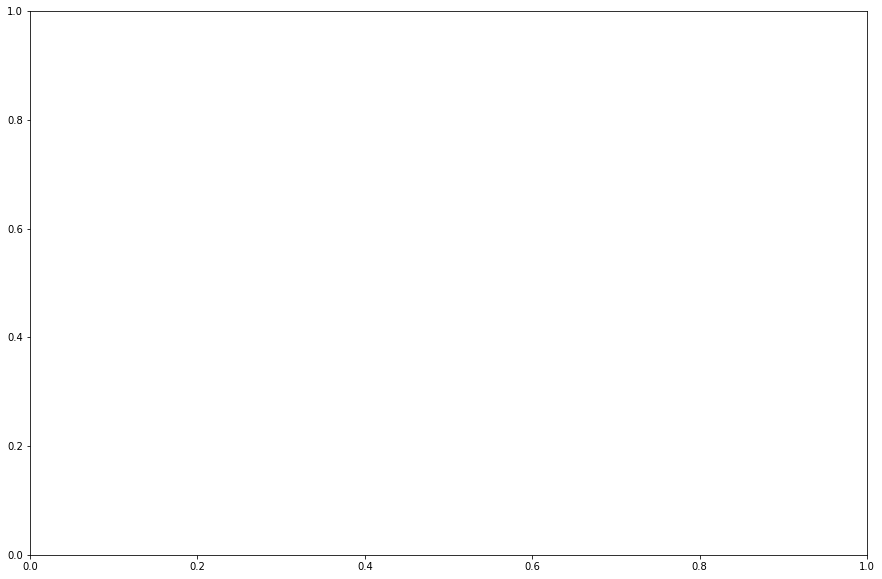

In [29]:
with torch.no_grad():
    model(image)
    tracker.add_saturations()

In [30]:
losses = []
raw_losses = []
recons = []
kls = []

100%|████████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [1,  7450] loss: 0.04920382]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_2.png


100%|████████████| 7487/7486.70703125 [10:50<00:00, 11.51batch/s, [2,  7450] loss: 0.04808088]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_3.png


100%|████████████| 7487/7486.70703125 [10:49<00:00, 11.52batch/s, [3,  7450] loss: 0.04794807]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_4.png


100%|████████████| 7487/7486.70703125 [10:50<00:00, 11.51batch/s, [4,  7450] loss: 0.04753236]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_5.png


100%|████████████| 7487/7486.70703125 [10:50<00:00, 11.51batch/s, [5,  7450] loss: 0.04719648]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_6.png


100%|████████████| 7487/7486.70703125 [10:49<00:00, 11.52batch/s, [6,  7450] loss: 0.04696841]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_7.png


100%|████████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [7,  7450] loss: 0.04713821]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_8.png


100%|████████████| 7487/7486.70703125 [10:49<00:00, 11.52batch/s, [8,  7450] loss: 0.04652347]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_9.png


100%|████████████| 7487/7486.70703125 [10:49<00:00, 11.52batch/s, [9,  7450] loss: 0.04599328]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_10.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.52batch/s, [10,  7450] loss: 0.04645854]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_11.png


100%|███████████| 7487/7486.70703125 [10:50<00:00, 11.51batch/s, [11,  7450] loss: 0.04674215]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_12.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.52batch/s, [12,  7450] loss: 0.04610734]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_13.png


100%|███████████| 7487/7486.70703125 [10:50<00:00, 11.52batch/s, [13,  7450] loss: 0.04586140]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_14.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.52batch/s, [14,  7450] loss: 0.04591847]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_15.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [15,  7450] loss: 0.04612281]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_16.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [16,  7450] loss: 0.04616831]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_17.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [17,  7450] loss: 0.04606801]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_18.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [18,  7450] loss: 0.04612932]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_19.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [19,  7450] loss: 0.04596661]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_20.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [20,  7450] loss: 0.04605703]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_21.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [21,  7450] loss: 0.04553279]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_22.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [22,  7450] loss: 0.04557860]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_23.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.53batch/s, [23,  7450] loss: 0.04537651]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_24.png


100%|███████████| 7487/7486.70703125 [10:49<00:00, 11.54batch/s, [24,  7450] loss: 0.04525487]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_25.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [25,  7450] loss: 0.04558662]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_26.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [26,  7450] loss: 0.04524428]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_27.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [27,  7450] loss: 0.04543968]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_28.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [28,  7450] loss: 0.04520992]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_29.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [29,  7450] loss: 0.04537540]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_30.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [30,  7450] loss: 0.04553774]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_31.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [31,  7450] loss: 0.04551387]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_32.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [32,  7450] loss: 0.04544161]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_33.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [33,  7450] loss: 0.04545702]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_34.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [34,  7450] loss: 0.04527026]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_35.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.54batch/s, [35,  7450] loss: 0.04554717]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_36.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [36,  7450] loss: 0.04561366]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_37.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [37,  7450] loss: 0.04521839]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_38.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [38,  7450] loss: 0.04519199]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_39.png


100%|███████████| 7487/7486.70703125 [10:47<00:00, 11.55batch/s, [39,  7450] loss: 0.04530895]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_40.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [40,  7450] loss: 0.04530108]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_41.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [41,  7450] loss: 0.04503006]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_42.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [42,  7450] loss: 0.04545944]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_43.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [43,  7450] loss: 0.04506417]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_44.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [44,  7450] loss: 0.04547241]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_45.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [45,  7450] loss: 0.04529081]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_46.png


100%|███████████| 7487/7486.70703125 [10:47<00:00, 11.56batch/s, [46,  7450] loss: 0.04544196]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_47.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [47,  7450] loss: 0.04519529]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_48.png


100%|███████████| 7487/7486.70703125 [10:47<00:00, 11.55batch/s, [48,  7450] loss: 0.04548266]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_49.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [49,  7450] loss: 0.04505004]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_50.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [50,  7450] loss: 0.04526710]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_51.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [51,  7450] loss: 0.04538617]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_52.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [52,  7450] loss: 0.04537065]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_53.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [53,  7450] loss: 0.04518996]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_54.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [54,  7450] loss: 0.04499130]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_55.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [55,  7450] loss: 0.04513822]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_56.png


100%|███████████| 7487/7486.70703125 [10:48<00:00, 11.55batch/s, [56,  7450] loss: 0.04550824]


metrics/2021-09-23T22:39:03.098016/my_experiment_lsat_train_epoch_57.png


 33%|███▋       | 2484/7486.70703125 [03:34<07:12, 11.57batch/s, [57,  2450] loss: 0.04502226]


KeyboardInterrupt: 

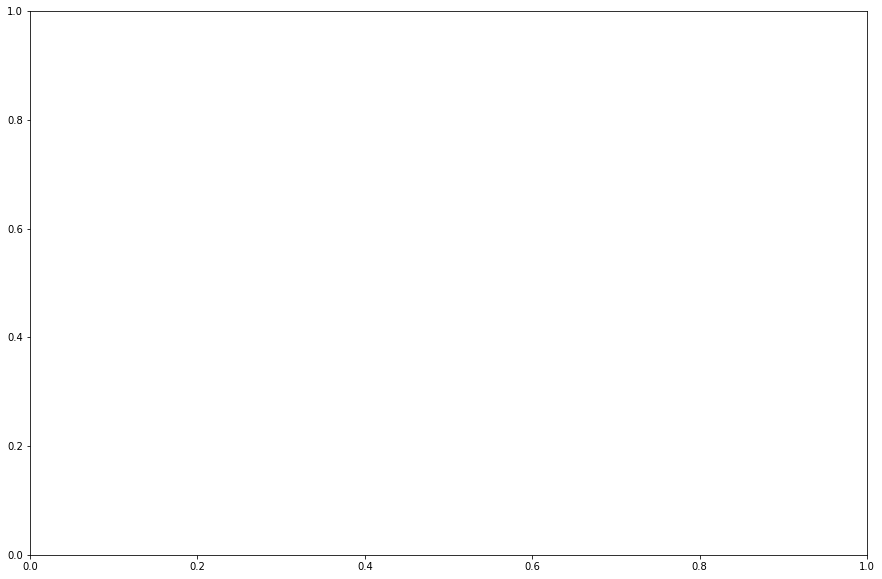

In [43]:
loss_steps = 50
epochs = 100

for epoch in range(epochs):
    running_loss = 0
    with tqdm(enumerate(train_dataloader, 0), total=len(dataset)/BATCH_SIZE, unit="batch") as t:
        for i, data in t:
            # get the inputs
    #         current_state, action, reward, next_state, done = data
            image = data.permute(0, 3, 1, 2).cuda() / 255

    #         loss = train_batch(image, model, optimizer, autoencoder.spectral_loss)
            full_loss = train_batch(image, model, optimizer, loss_func)

            if isinstance(full_loss, tuple):
                loss = full_loss[0].item()
                raw_losses.append(loss)
                recons.append(full_loss[1].item())
                kls.append(full_loss[2].item())
            else:
                loss = full_loss.item()
                raw_losses.append(loss)


            # print statistics
            running_loss += loss
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                losses.append(running_loss / loss_steps)
    #             scheduler.step(running_loss)
                running_loss = 0.0
    tracker.add_saturations()

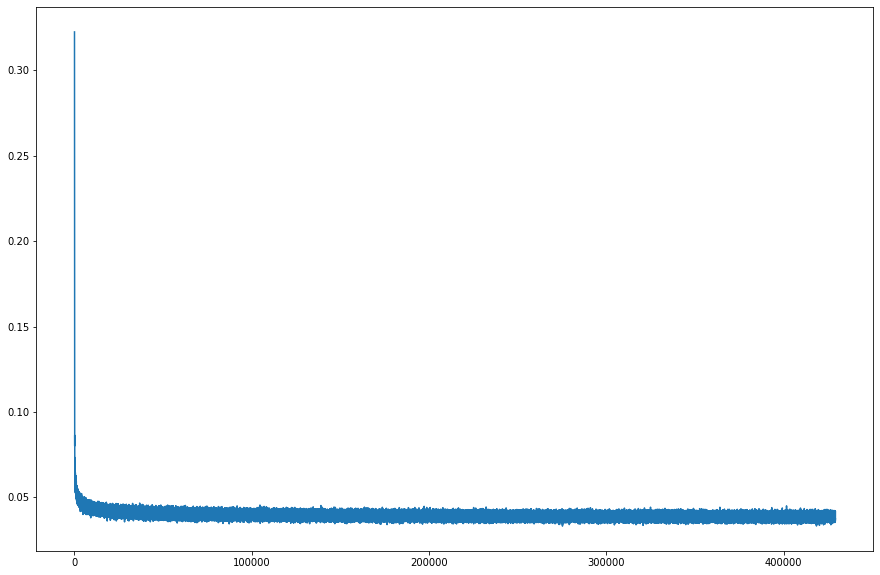

In [47]:
plt.plot(recons)
# plt.yscale('log')
# plt.xscale('log')

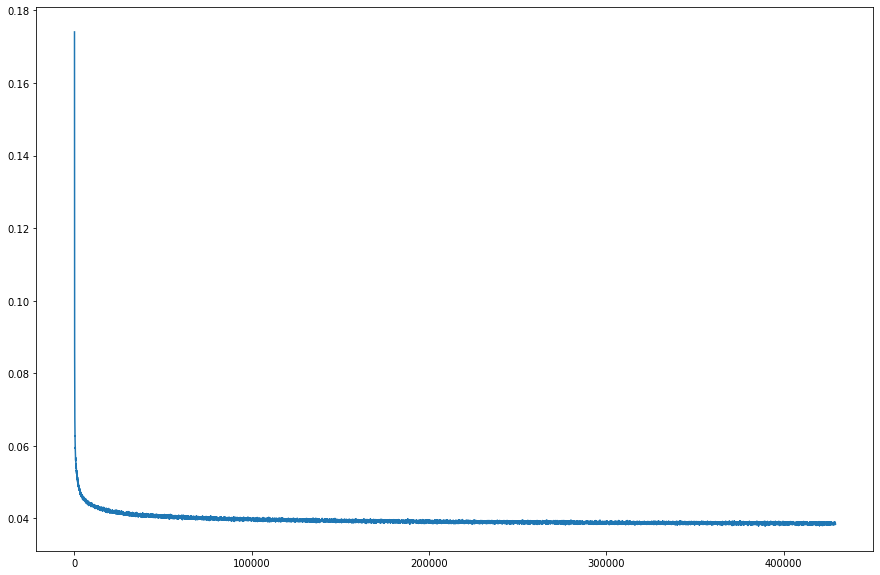

In [48]:
plt.plot(np.convolve(np.asarray(recons), np.ones(50)/50, mode='valid'))

In [49]:
image = train_features.permute(0, 3, 1, 2).cuda() / 255

In [50]:
outputs, latents = model(image)

In [51]:
op = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)

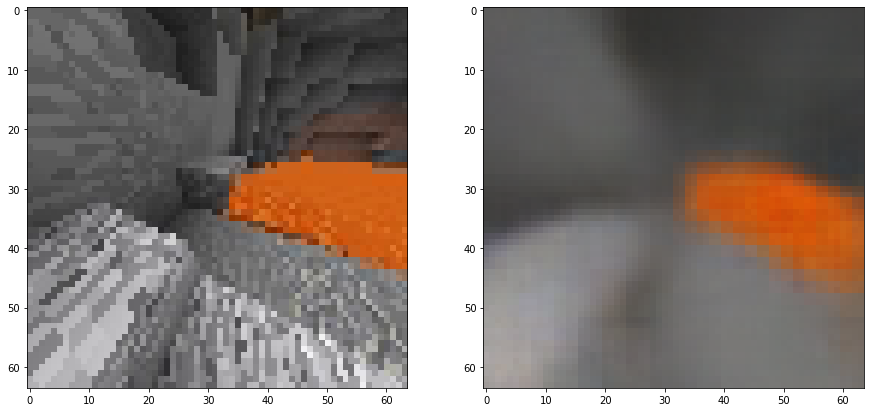

In [53]:
idx = 3 #62#3#33
plt.subplot(1, 2, 1)
plt.imshow(train_features[idx])
plt.subplot(1, 2, 2)

plt.imshow(op[idx])

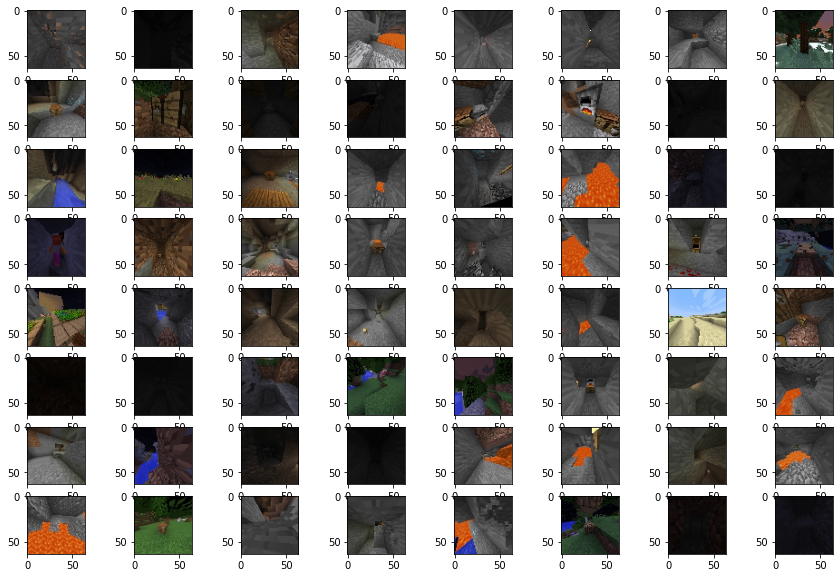

In [39]:
height = 8
width = 8

for i in range(height):
    for j in range(width):
        idx = i*width+j
        plt.subplot(height, width, idx+1)
        plt.imshow(train_features[idx])
        

In [73]:
np.mean(np.abs(train_features[idx]-op[idx]).numpy())

63.012188

In [74]:
np.mean(np.abs(train_features[0]-op[0]).numpy())

73.124626

In [75]:
np.mean(np.abs(train_features[7]-op[7]).numpy())

63.653656

In [41]:
F.l1_loss(train_features[7]/255.0, torch.tensor(op[7]))

tensor(0.0411)

In [42]:
F.l1_loss(train_features[0]/255.0, torch.tensor(op[0]))

tensor(0.0230)

In [43]:
# torch.save(model.state_dict(), "models/vision_50_epochs.mdl")

In [51]:
torch.save(model.state_dict(), "models/vision_10_epochs.mdl")

In [116]:
256/(64*64*3)

0.020833333333333332

In [42]:
kls[:10]

[0.37565237283706665,
 0.2078263759613037,
 0.13038288056850433,
 0.08894361555576324,
 0.062129586935043335,
 0.044747620820999146,
 0.03329959511756897,
 0.026387911289930344,
 0.02004087343811989,
 0.017980841919779778]